# Imports

In [2]:
import warnings
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from dstoolkit.automl.classifier import AutoMLLightGBM, AutoMLLightGBMCV

/home/junior/Documentos/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")

## Functions

In [4]:
def generate_synthetic_binary_data(
    n_samples=10000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,
    flip_y=0.15,
    weights=[0.8, 0.2],
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera uma base sintética binária com splits train/valid/test.
    Retorna: (X_train, y_train, X_valid, y_valid, X_test, y_test)
    """

    # ---------------------------
    # 1. Gerar base sintética
    # ---------------------------
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=n_classes,
        class_sep=class_sep,
        flip_y=flip_y,
        weights=weights,
        random_state=random_state
    )

    # ---------------------------
    # 2. Train/Test
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # ---------------------------
    # 3. Train/Validation
    # ---------------------------
    valid_relative = valid_size / (1 - test_size)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=valid_relative,
        stratify=y_train,
        random_state=random_state
    )

    y_train = pd.DataFrame(y_train, columns=['target'])
    y_valid = pd.DataFrame(y_valid, columns=['target'])
    y_test = pd.DataFrame(y_test, columns=['target'])
    
    return pd.DataFrame(X_train), y_train, pd.DataFrame(X_valid), y_valid, pd.DataFrame(X_test), y_test

# Data Base

In [5]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_binary_data(
    n_samples=5000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,   # classes mais misturadas
    flip_y=0.15,     # ruído nos rótulos
    weights=[0.8, 0.2],  # desbalanceamento
    test_size=0.2,
    valid_size=0.2,
    random_state=42
)


# Modeling

## LightGBM

In [6]:
lgbm = AutoMLLightGBM(scoring='ks', tune=True, n_trials=20)
lgbm.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [7]:
lgbm.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.818039,0.967347,0.643148,0.772616,0.986658,0.884235,0.067234,0.252537
Valid,0.702527,0.800000,0.440816,0.568421,0.811623,0.543452,0.126015,0.411312
Test,0.701866,0.716981,0.463415,0.562963,0.803595,0.519021,0.131044,0.424677


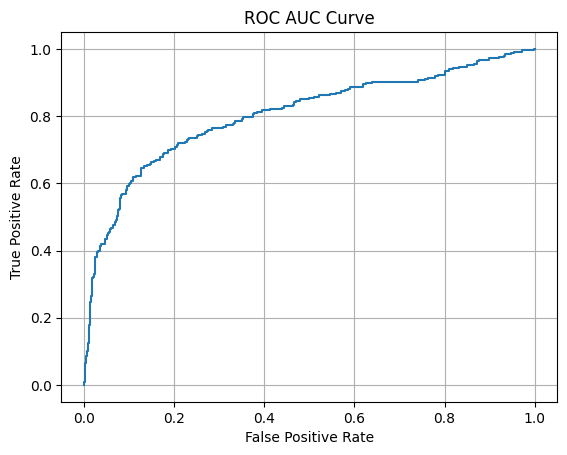

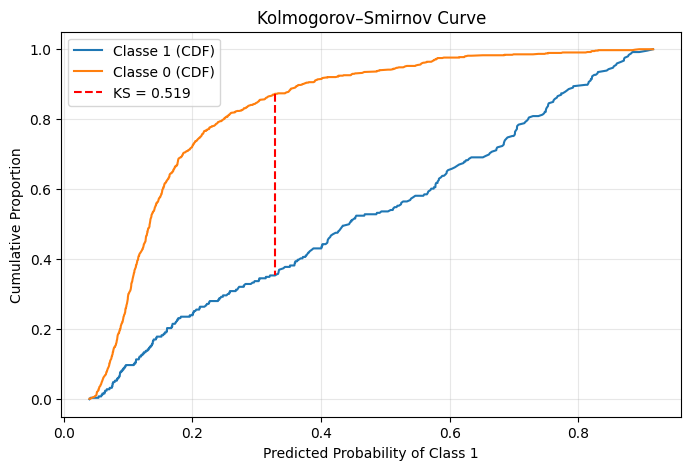

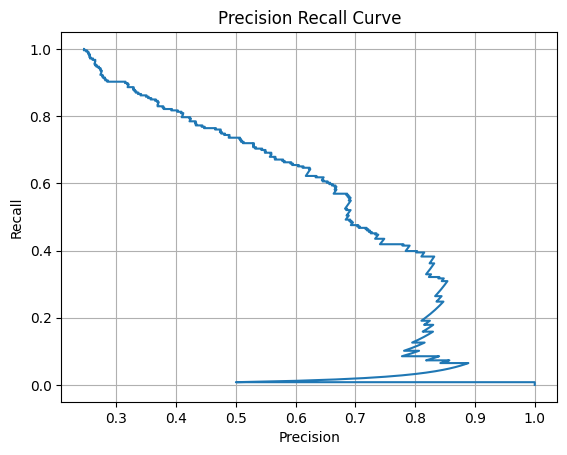

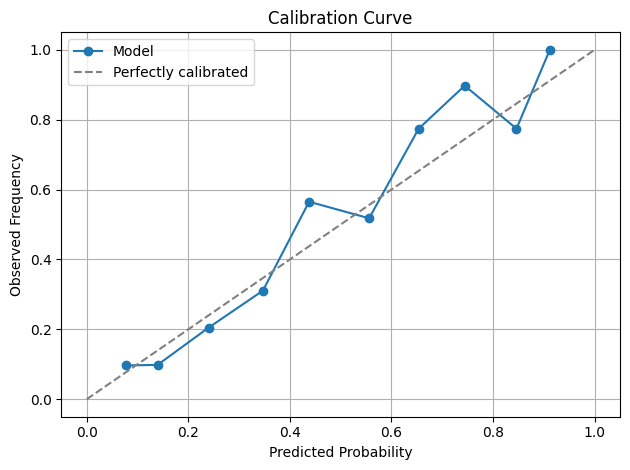

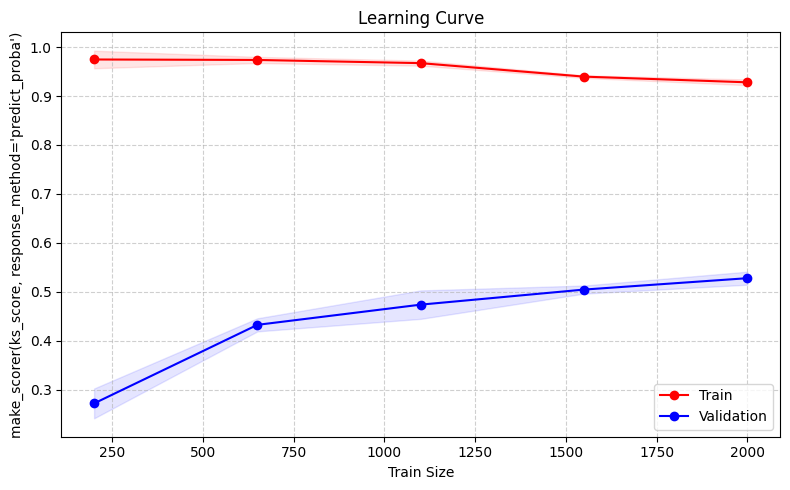

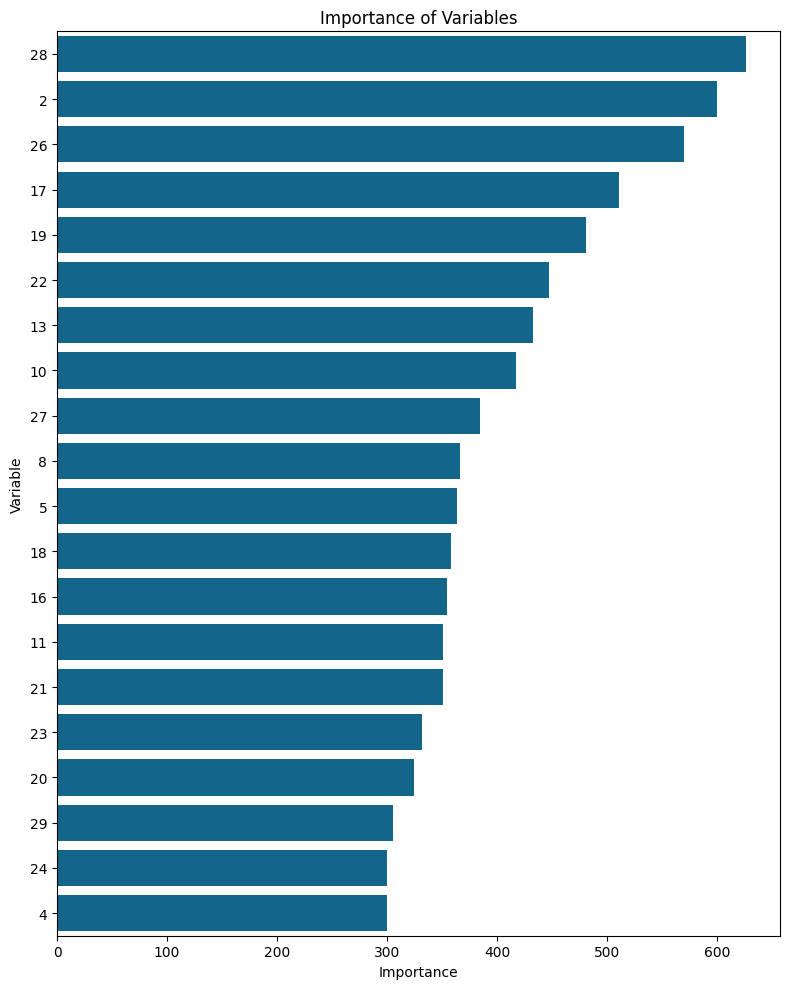

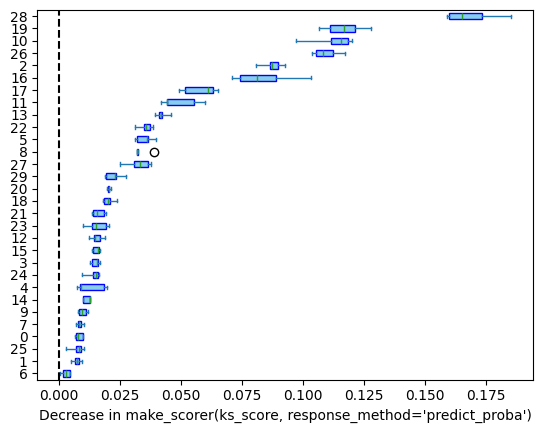

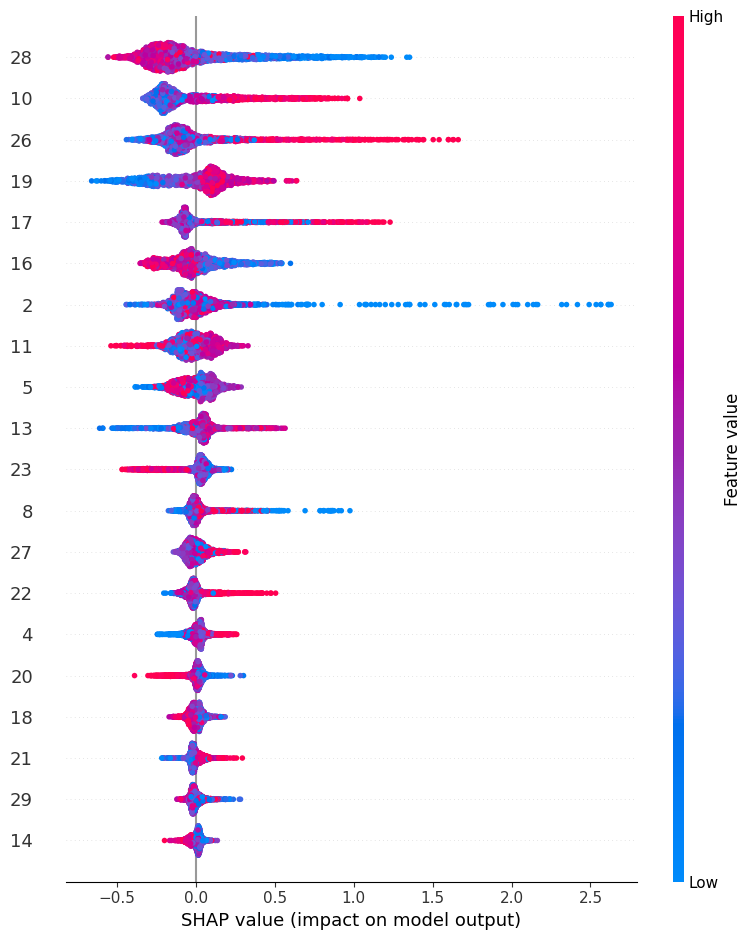

In [8]:
lgbm.analyze()

In [1]:
from dstoolkit.metrics.scores import average_precision_lift_score

## LightGBM CV

In [8]:
lgbm_cv = AutoMLLightGBMCV(scoring='roc_auc', tune=True)
lgbm_cv.train(X_train, y_train, X_test, y_test)

In [10]:
lgbm_cv.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.655900,0.801282,0.339196,0.476627,0.809892,0.523009,0.135006,0.433211
Test,0.685348,0.787402,0.406504,0.536193,0.812415,0.523894,0.132273,0.427444


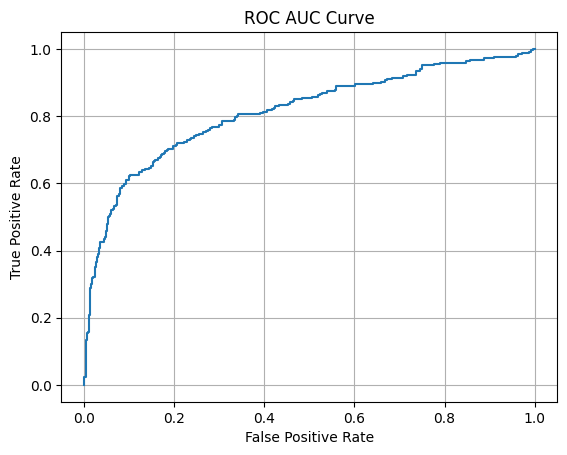

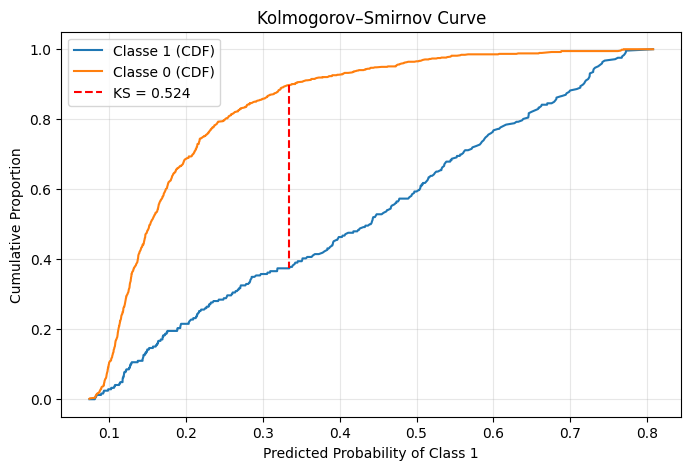

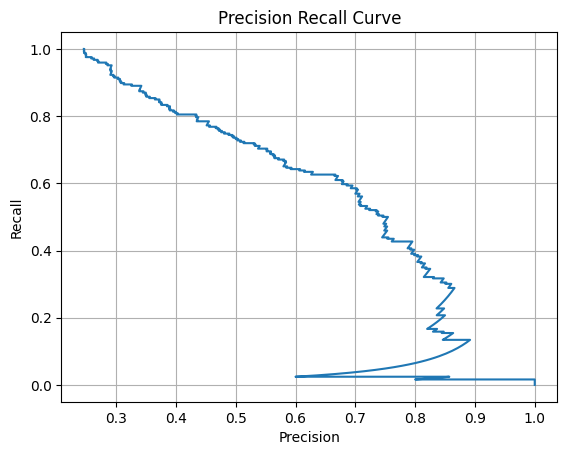

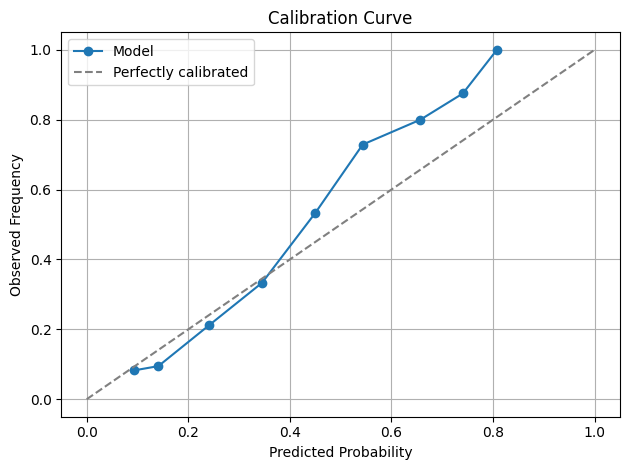

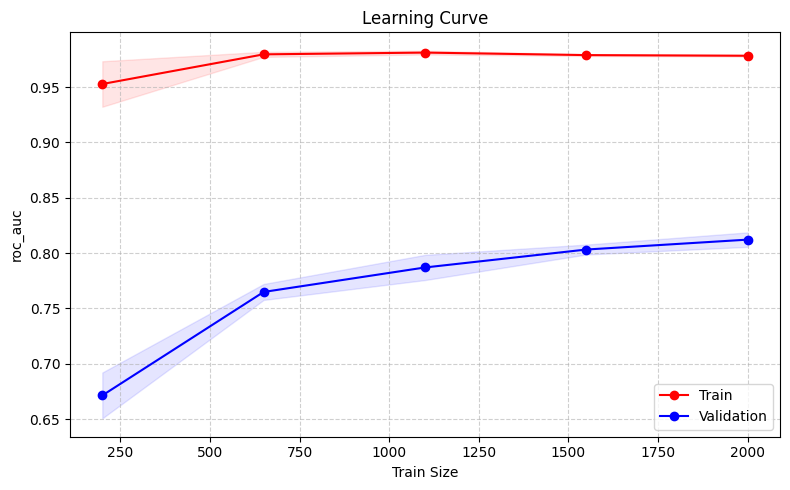

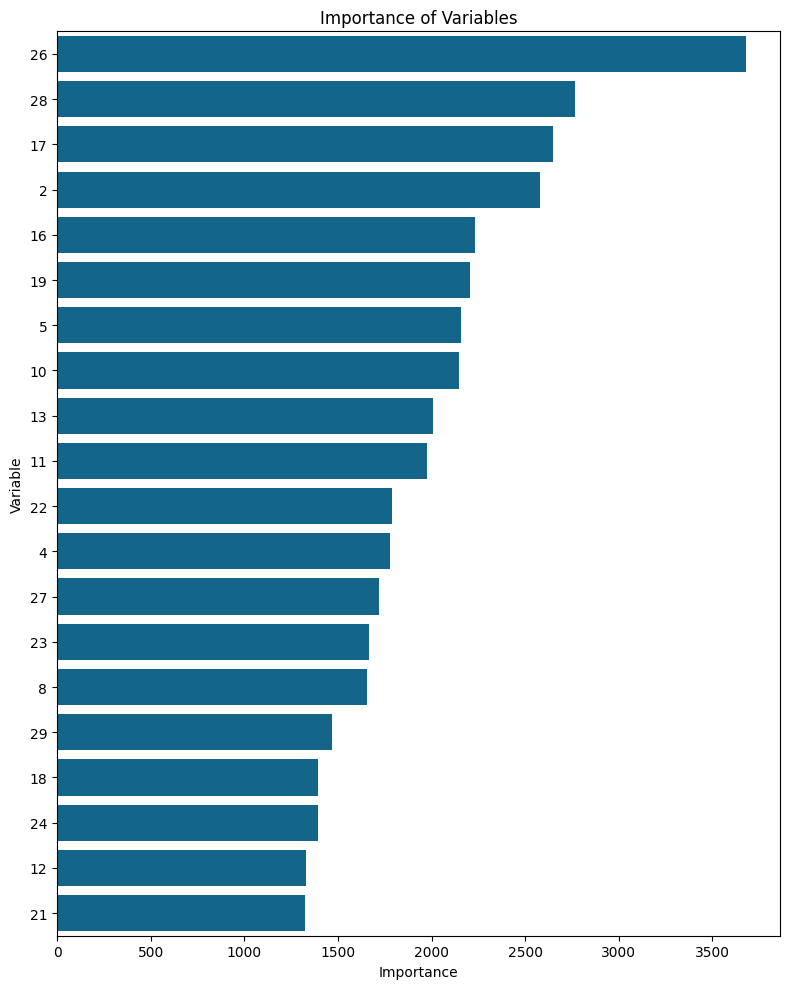

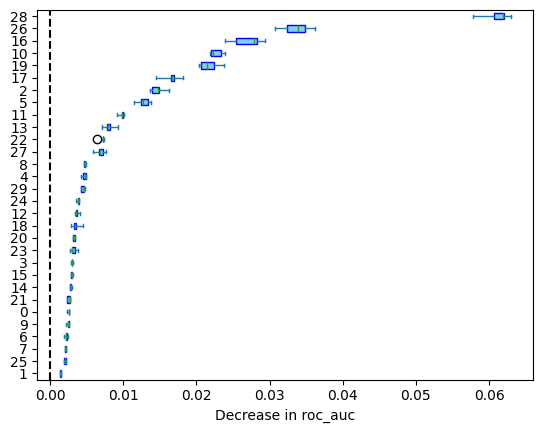

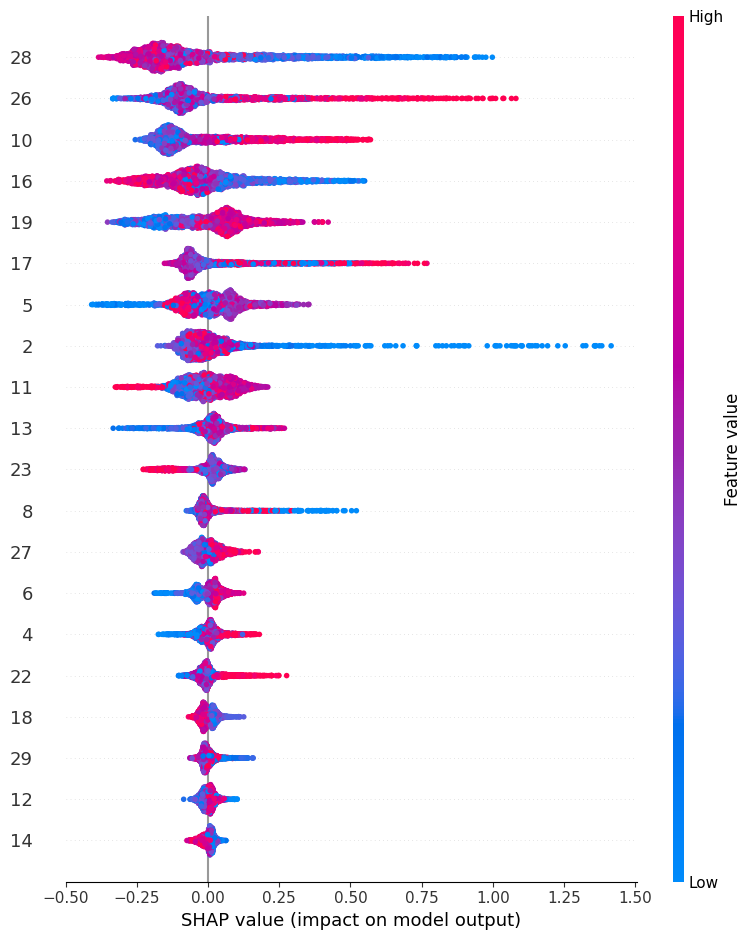

In [11]:
lgbm_cv.analyze()